In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
df = pd.read_csv('data/strat.csv')

In [2]:
print(df.shape)
df.dropna(subset=['MPCE_qrt'], inplace=True)
print(df.shape)

(382223, 31)
(382219, 31)


In [3]:
from sklearn.preprocessing import OneHotEncoder

In [4]:
df.head()

,Age,Gender,state_codes,Total Children in HH,Total Women in HH,Total Additional Women in HH,education,marital_status,employment,Social_group_,...,Time Spent on Unpaid Work,Time Spent on Leisure,Time Spent Cooking,Time Spent Cleaning,Time Spent Collecting Firewood,Time Spent Washing,Time Spent on Domestic Chores,Time Spent on Care Work,young_old,stratcode
0,67,Male,TN,1.0,2,1,Secondary,Currently Married,Self-Employed,OBC,...,45.0,165.0,0.0,0.0,0.0,0.0,0.0,45.0,Old,Old_TN_Male_OBC_Hinduism_Rural
1,61,Female,TN,1.0,2,1,Upto Middle School,Currently Married,Casual Labour,OBC,...,225.0,195.0,165.0,0.0,0.0,0.0,165.0,60.0,Old,Old_TN_Female_OBC_Hinduism_Rural
2,33,Male,TN,1.0,2,1,Secondary,Currently Married,Salaried Employee,OBC,...,15.0,105.0,0.0,0.0,0.0,0.0,0.0,15.0,Young,Young_TN_Male_OBC_Hinduism_Rural
3,26,Female,TN,1.0,2,1,Secondary,Currently Married,Not Employed,OBC,...,645.0,45.0,135.0,90.0,0.0,120.0,345.0,120.0,Young,Young_TN_Female_OBC_Hinduism_Rural
4,70,Female,TN,0.0,1,0,Illiterate,Widowed,Not Employed,OBC,...,105.0,225.0,105.0,0.0,0.0,0.0,105.0,0.0,Old,Old_TN_Female_OBC_Hinduism_Rural


In [5]:
from shap import TreeExplainer, decision_plot, Explainer
from shap.plots import beeswarm
import matplotlib.pyplot as plt

In [15]:
# eqn 1

results = []
for gender, target, spec_col in zip(
    ['Male', 'Male', 'Female', 'Female'],
    ['Time Spent on Paid Work', 'Time Spent on Unpaid Work', 'Time Spent on Paid Work', 'Time Spent on Unpaid Work'],
    ['Total Women in HH', 'Total Women in HH', 'Total Additional Women in HH', 'Total Additional Women in HH']):

    xdf = df[df['Gender'] == gender]

    train_df, test_df = train_test_split(xdf, train_size=0.8, stratify=xdf['stratcode'])

    ytrain, ytest = train_df[target] / 60, test_df[target] / 60
    feats = ['Total Children in HH', spec_col, 'education', 'marital_status', 'employment', 'Age', 'MPCE_qrt', 'state_codes']
    xtrain, xtest = train_df[feats], test_df[feats]

    catCols = ['education', 'marital_status', 'employment', 'state_codes', 'MPCE_qrt']

    oenc = Pipeline(steps=[
        ('ordinal', OrdinalEncoder())
    ])
    ohenc = OneHotEncoder(sparse_output=False)
    ohenc.set_output(transform='pandas')

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', ohenc, catCols)
        ],
        remainder='passthrough'
    )
    # lr_prep = ColumnTransformer(
    #     transformers = [('cat', ohenc, catCols)],
    #     remainder='passthrough'
    # )

    pipeline_rf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=40, n_jobs=-1))
    ])
    pipeline_dt = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor())
    ])
    pipeline_lr = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])
    
    pipeline_rf.fit(xtrain, ytrain)
    pipeline_dt.fit(xtrain, ytrain)
    pipeline_lr.fit(xtrain, ytrain)
    rf_train_score, rf_test_score = pipeline_rf.score(xtrain, ytrain), pipeline_rf.score(xtest, ytest)
    dt_train_score, dt_test_score = pipeline_dt.score(xtrain, ytrain), pipeline_dt.score(xtest, ytest) 
    lr_train_score, lr_test_score = pipeline_lr.score(xtrain, ytrain), pipeline_lr.score(xtest, ytest) 
    # print(f"{gender}, {target}: ", rf_train_score, rf_test_score)
    # print(f"{gender}, {target}: ", dt_train_score, dt_test_score)
    results.append((gender, target, rf_train_score, rf_test_score, dt_train_score, dt_test_score, lr_train_score, lr_test_score))
    # exp = TreeExplainer(pipeline_rf.named_steps['regressor'])
    # vals = exp(pipeline_rf.named_steps['preprocessor'].transform(xtrain.sample(100)), check_additivity=False)
    # plt.figure()
    # beeswarm(vals, color='RdYlGn')

rdf = pd.DataFrame(results, columns=['Gender', 'Target', 'RF (Train)', 'RF (Test)', 'DT (Train)', 'DT (Test)', 'LR (Train)', 'LR (Test)'])
# rdf.to_csv('data/cv_results_eqn1.csv', index=False)
rdf.round(2)

,Gender,Target,RF (Train),RF (Test),DT (Train),DT (Test),LR (Train),LR (Test)
0,Male,Time Spent on Paid Work,0.80,0.37,0.86,0.06,0.45,0.45
1,Male,Time Spent on Unpaid Work,0.69,0.02,0.77,-0.47,0.13,0.13
2,Female,Time Spent on Paid Work,0.85,0.47,0.90,0.20,0.53,0.53
3,Female,Time Spent on Unpaid Work,0.79,0.42,0.84,0.17,0.43,0.43


In [14]:
pd.read_csv('data/cv_results_eqn1.csv').round(2)

,Gender,Target,RF (Train),RF (Test),DT (Train),DT (Test),LR (Train),LR (Test)
0,Male,Time Spent on Paid Work,0.81,0.36,0.86,0.05,0.45,0.44
1,Male,Time Spent on Unpaid Work,0.70,0.01,0.78,-0.47,0.13,0.12
2,Female,Time Spent on Paid Work,0.85,0.46,0.90,0.15,0.53,0.52
3,Female,Time Spent on Unpaid Work,0.80,0.41,0.84,0.15,0.44,0.43


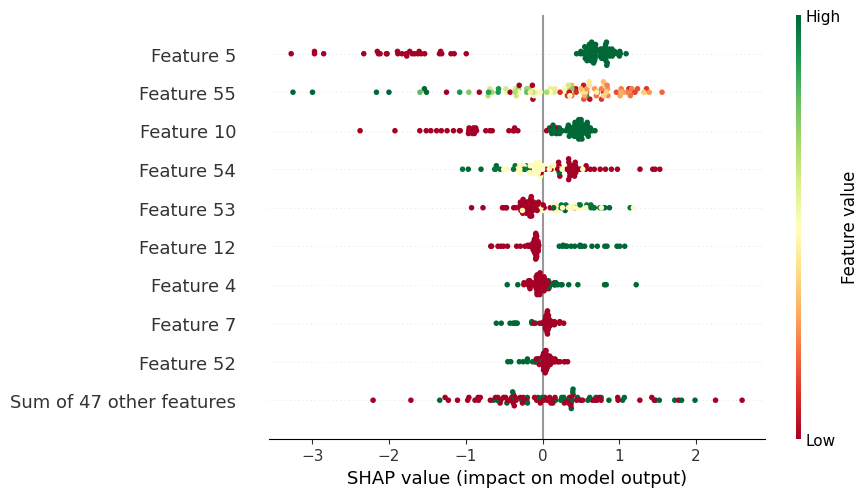

In [7]:
exp = TreeExplainer(pipeline_rf.named_steps['regressor'], feature_perturbation='tree_path_dependent')
vals = exp(pipeline_rf.named_steps['preprocessor'].transform(xtrain.sample(100)), check_additivity=False)
plt.figure()
beeswarm(vals, color='RdYlGn')

---
## Eqn 3

In [6]:
target_names = ['Time Spent on Paid Work',
                'Time Spent on Unpaid Work',
                'Time Spent on Leisure',
                'Time Spent Cooking',
                'Time Spent Cleaning',
                'Time Spent Collecting Firewood',
                'Time Spent Washing',
                'Time Spent on Domestic Chores',
                'Time Spent on Care Work']
resultdf = pd.DataFrame({'target': target_names, 'train': 0, 'test': 0})
xdf = df[df['Gender'] == 'Female']
feats = ['Social_group_', 'religion', 'sector', 'MPCE_qrt', 'Age', 'education', 'employment', 'marital_status', 'piped_gas', 'wired_source', 'sweeeping_type', 'child', 'old', 'n_unemp_men', 'state_codes']
catCols = feats.copy()
catCols.remove('Age')
catCols.remove('n_unemp_men')

results = []
for target in target_names:
    dftrain, dftest = train_test_split(xdf, stratify=xdf['stratcode'])
    xtrain, xtest = dftrain[feats], dftest[feats]
    ytrain, ytest = dftrain[target], dftest[target]
    oenc = Pipeline(steps=[
        ('ordinal', OrdinalEncoder())
    ])
    ohenc = Pipeline(steps=[('onehot', OneHotEncoder())])

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', oenc, catCols)
        ],
        remainder='passthrough'
    )
    lr_prep = ColumnTransformer(
        transformers = [('cat', ohenc, catCols)],
        remainder='passthrough'
    )

    pipeline_rf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_jobs=-1))
    ])
    pipeline_dt = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor())
    ])
    pipeline_lr = Pipeline(steps=[
        ('preprocessor', lr_prep),
        ('regressor', LinearRegression())
    ])
    pipeline_rf.fit(xtrain, ytrain)
    pipeline_dt.fit(xtrain, ytrain)
    pipeline_lr.fit(xtrain, ytrain)
    rf_train_score, rf_test_score = pipeline_rf.score(xtrain, ytrain), pipeline_rf.score(xtest, ytest)
    dt_train_score, dt_test_score = pipeline_dt.score(xtrain, ytrain), pipeline_dt.score(xtest, ytest) 
    lr_train_score, lr_test_score = pipeline_lr.score(xtrain, ytrain), pipeline_lr.score(xtest, ytest) 
    results.append((target, rf_train_score, rf_test_score, dt_train_score, dt_test_score, lr_train_score, lr_test_score))

rdf3 = pd.DataFrame(results, columns=['Target', 'RF (Train)', 'RF (Test)', 'DT (Train)', 'DT (Test)', 'LR (Train)', 'LR (Test)'])
rdf3.to_csv('data/cv_results_eqn3.csv', index=False)
rdf3

,Target,RF (Train),RF (Test),DT (Train),DT (Test),LR (Train),LR (Test)
0,Time Spent on Paid Work,0.905003,0.499561,0.963802,0.114214,0.529253,0.526948
1,Time Spent on Unpaid Work,0.875495,0.432615,0.936309,0.051024,0.430881,0.434792
2,Time Spent on Leisure,0.792833,0.081411,0.888682,-0.522495,0.180908,0.178289
3,Time Spent Cooking,0.850811,0.331322,0.921379,-0.112898,0.344989,0.349894
4,Time Spent Cleaning,0.773613,0.024703,0.873661,-0.628305,0.126290,0.119419
5,Time Spent Collecting Firewood,0.733928,-0.147928,0.848987,-0.907321,0.041125,0.037825
6,Time Spent Washing,0.782255,0.039036,0.881504,-0.578742,0.143269,0.143032
7,Time Spent on Domestic Chores,0.859908,0.362353,0.926641,-0.070041,0.370626,0.366511
8,Time Spent on Care Work,0.849321,0.347228,0.916062,-0.098721,0.382243,0.384557
